The SSVI ("surface SVI") sub-family


#### Objective
The goal of this projectis to fit the SSVI parametric model to the market implied volatility smile for the SPX index via the minimization of a square loss function, and then to analyse the no arbitrage conditions for the parametrisation we obtain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Fitting the SSVI parametric model

We consider end-of-day option quotes for the SPX stock index, observation date = Friday 14 03 2024, with different expiration dates (from April 05 2024 to June 21 2024).

In [2]:
import os
files = os.listdir()
file_list = [file for file in files if os.path.isfile(file)]
directory = 'cleaned_spx_vol'
files = os.listdir(directory)
file_list = [file for file in files if os.path.isfile(os.path.join(directory, file))]

maturities = [float(file.split("_")[0]) for file in file_list]

In [3]:
quotes_dict = {}
mkt_log_mon_dict = {}
vols_calls_dict = {}

for i, maturity in enumerate(maturities):
    quotes = np.loadtxt(open(f"{directory}/{file_list[i]}", "r"), delimiter=";")
    print("quotes.shape : ", quotes.shape)
    quotes_dict[maturity] = quotes
    
    mkt_log_mon = quotes[0]
    vols_calls = quotes[1]
    
    mkt_log_mon_dict[maturity] = mkt_log_mon
    vols_calls_dict[maturity] = vols_calls

quotes.shape :  (2, 129)
quotes.shape :  (2, 108)
quotes.shape :  (2, 80)
quotes.shape :  (2, 187)
quotes.shape :  (2, 296)
quotes.shape :  (2, 215)


Let us plot the implied volatility smile in terms of the log-forward moneyness $k = \log(K / F_0^T)$ for each maturity :

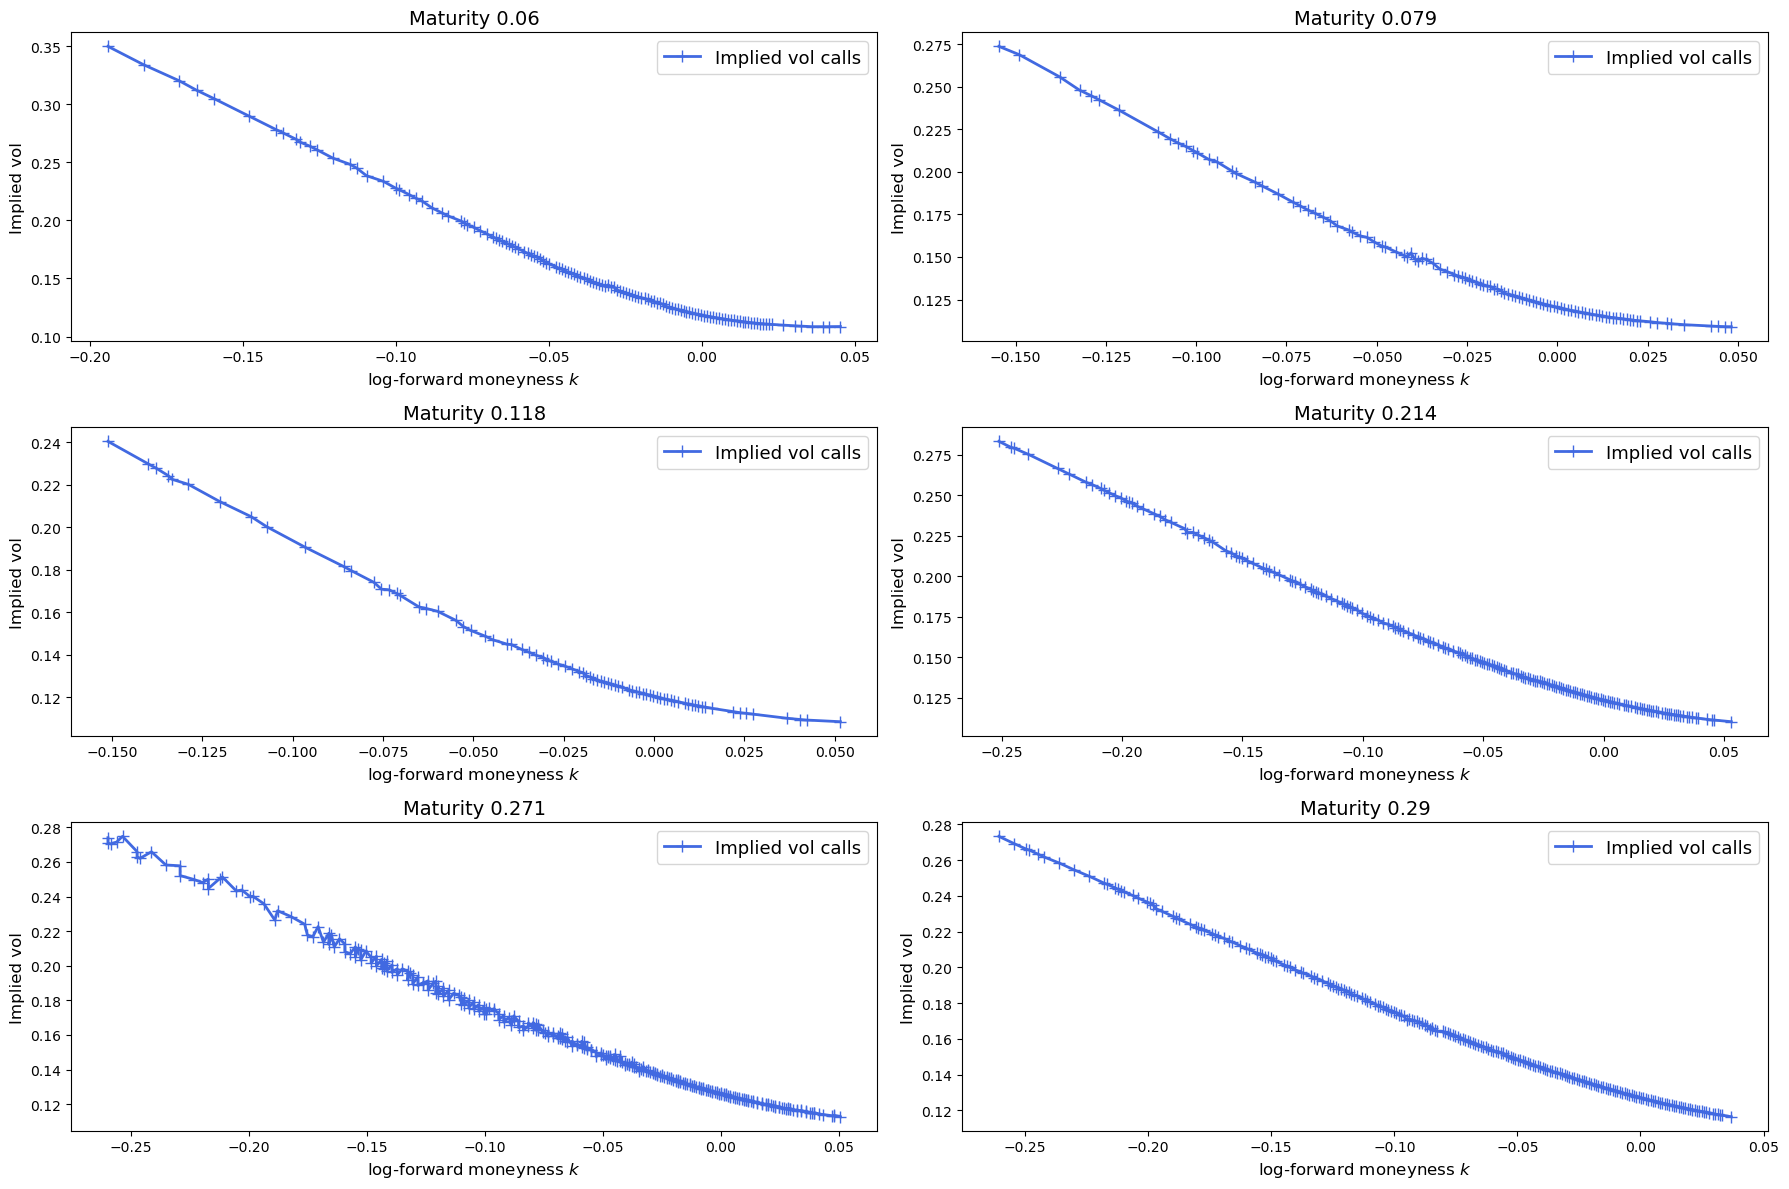

In [4]:
num_maturities = len(maturities)

fig, axes = plt.subplots(3, 2, figsize=(18, 12)) 
axes = axes.flatten()

for i, maturity in enumerate(maturities):
    mkt_log_mon = mkt_log_mon_dict[maturity]
    vols_calls = vols_calls_dict[maturity]

    ax = axes[i]
    ax.plot(mkt_log_mon, vols_calls, color='royalblue', linewidth=2, marker="+", markersize=8, label="Implied vol calls")
    ax.set_xlabel(r"log-forward moneyness $k$", fontsize=12)
    ax.set_ylabel("Implied vol", fontsize=12)
    ax.set_title(f"Maturity {maturity}", fontsize=14)
    ax.legend(loc="upper right", fontsize=13)

plt.tight_layout()
plt.show()

Now we fit an SSVI parameterisation to the market quotes (model learning from data) for each maturity

In [5]:
def SVI(k, a, b , rho, k_bar, sig):
    total_variance = a + b*(rho*(k-k_bar)+np.sqrt((k-k_bar)**2 + sig**2))
    
    return total_variance

def SSVI(k, theta, phi, rho):
    a = theta/2 * (1-rho**2)
    b = theta*phi/2
    k_bar = -rho/phi
    sig = np.sqrt(1-rho**2)/phi
    return SVI(k, a, b , rho, k_bar, sig)

def SSVI_two_arguments(args, k):
    theta, phi, rho = args
    
    return SSVI(k, theta, phi, rho)

def fct_least_squares(args, log_mon, tot_implied_variance):
    """
    args                : the vector of SSVI parameters
    log_mon              : log-forward moneyness k (float or double)
    tot_implied_variance : the target total implied variance (float or double)
    
    Returns : the objective function (without the square) to be injected
    in the least-square problem
    """
    return SSVI_two_arguments(args, log_mon) - tot_implied_variance

$\blacktriangleright$ Let us have a look at our initial guess for SSVI:

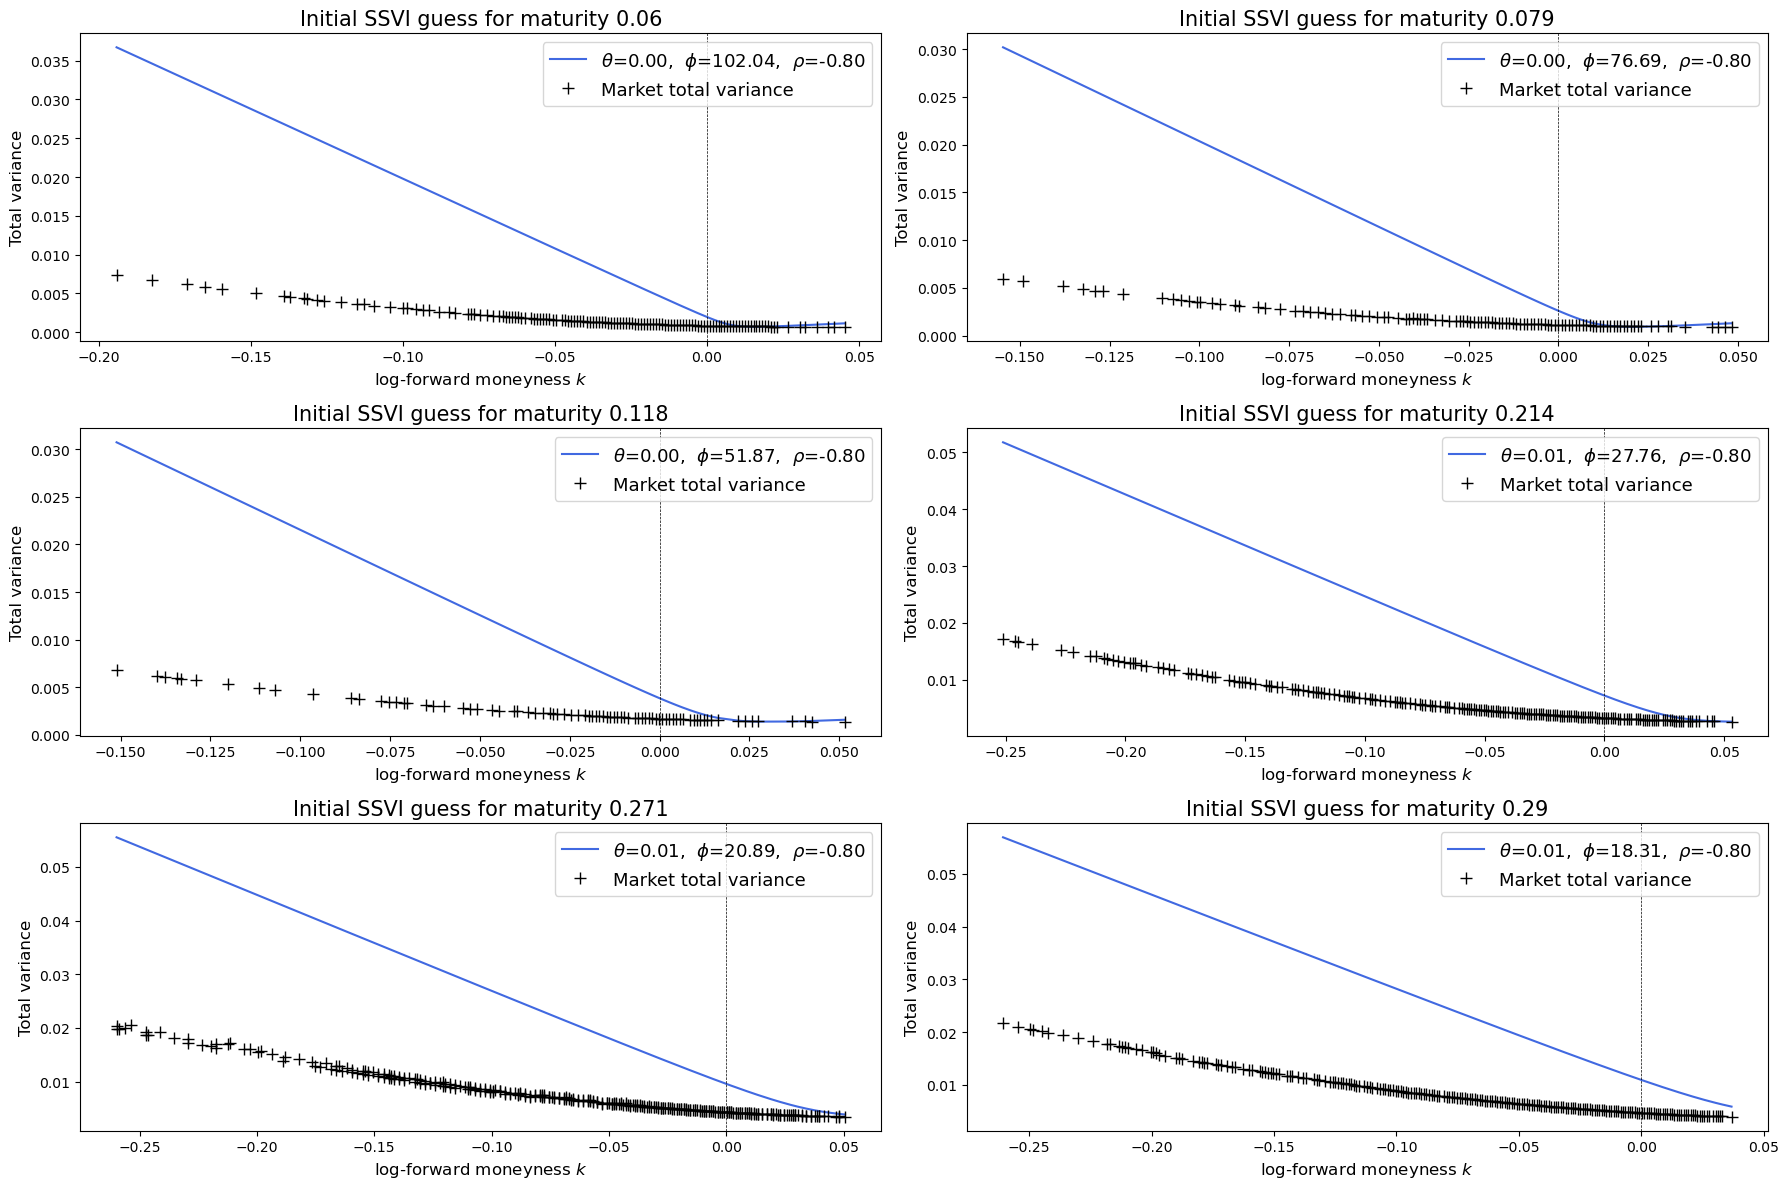

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(18, 12)) 

# Flatten axes array if necessary (for iterating)
axes = axes.flatten()

for i, maturity in enumerate(maturities):
    mkt_log_mon = mkt_log_mon_dict[maturity]
    vols_calls = vols_calls_dict[maturity]

    mkt_tot_variance = maturity * vols_calls**2

    ## Choice of initial point
    theta_init = np.min(mkt_tot_variance) / (1-0.8**2)  # Equivalent initialization as for a in SVI
    phi_init = 2*0.1 / theta_init  # Equivalent initialization as for b in SVI
    rho_init = -0.8
    
    total_variances_init = SSVI(mkt_log_mon, theta_init, phi_init, rho_init)

    ax = axes[i]
    ax.plot(mkt_log_mon, total_variances_init, color='royalblue', linewidth=1.5, label=r"$\theta$=%1.2f,  $\phi$=%1.2f,  $\rho$=%1.2f" % (theta_init, phi_init, rho_init))
    ax.plot(mkt_log_mon, mkt_tot_variance, color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")
    ax.axvline(0., linestyle="--", linewidth=0.5, color="k")
    ax.set_xlabel(r"log-forward moneyness $k$", fontsize=12)
    ax.set_ylabel("Total variance", fontsize=12)
    ax.set_title(r"Initial SSVI guess for maturity " + str(maturity), fontsize=15)
    ax.legend(loc="upper right", fontsize=13)

plt.tight_layout()
plt.show()


In [7]:
import scipy.optimize as opt

theta_star_dict = {}
phi_star_dict = {}
rho_star_dict = {}

lower = np.array([0.,   # theta
                  0.,   # phi
                  -1])  # rho


upper = np.array([1e6, # theta (infinity in theory)
                  1e6,  # phi (infinity in theory)
                  1])  # rho

SVI_param_bounds = (lower, upper)

for maturity in maturities:
    mkt_log_mon = mkt_log_mon_dict[maturity]
    vols_calls = vols_calls_dict[maturity]
    
    mkt_tot_variance = maturity * vols_calls**2

    ## Choice of initial point
    theta_init = np.min(mkt_tot_variance) / (1-0.8**2) # Equivalent initalization as for a in SVI
    phi_init = 2*0.1 / theta_init # Equivalent initalization as for b in SVI
    rho_init = -0.8

    args_init = np.array([theta_init, phi_init, rho_init])

    result = opt.least_squares(fun = fct_least_squares,
                               x0 = args_init, 
                               bounds = (lower, upper),
                               args = (mkt_log_mon, mkt_tot_variance), #additional arguments for the LS objective
                               verbose = 1)

    ## The optimized parameters
    theta_star, phi_star, rho_star = result.x
    
    theta_star_dict[maturity] = theta_star
    phi_star_dict[maturity] = phi_star
    rho_star_dict[maturity] = rho_star

`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 7.5102e-03, final cost 4.6733e-06, first-order optimality 5.20e-03.
`ftol` termination condition is satisfied.
Function evaluations 10, initial cost 4.7727e-03, final cost 1.7523e-06, first-order optimality 9.14e-06.
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 3.7113e-03, final cost 1.0584e-06, first-order optimality 9.45e-06.
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 2.5057e-02, final cost 2.0598e-05, first-order optimality 6.77e-05.
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 4.1392e-02, final cost 4.0200e-05, first-order optimality 1.19e-03.
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 3.7251e-02, final cost 2.3664e-05, first-order optimality 5.21e-05.


$\blacktriangleright$ Have a look at our SSVI fit of implied variance:

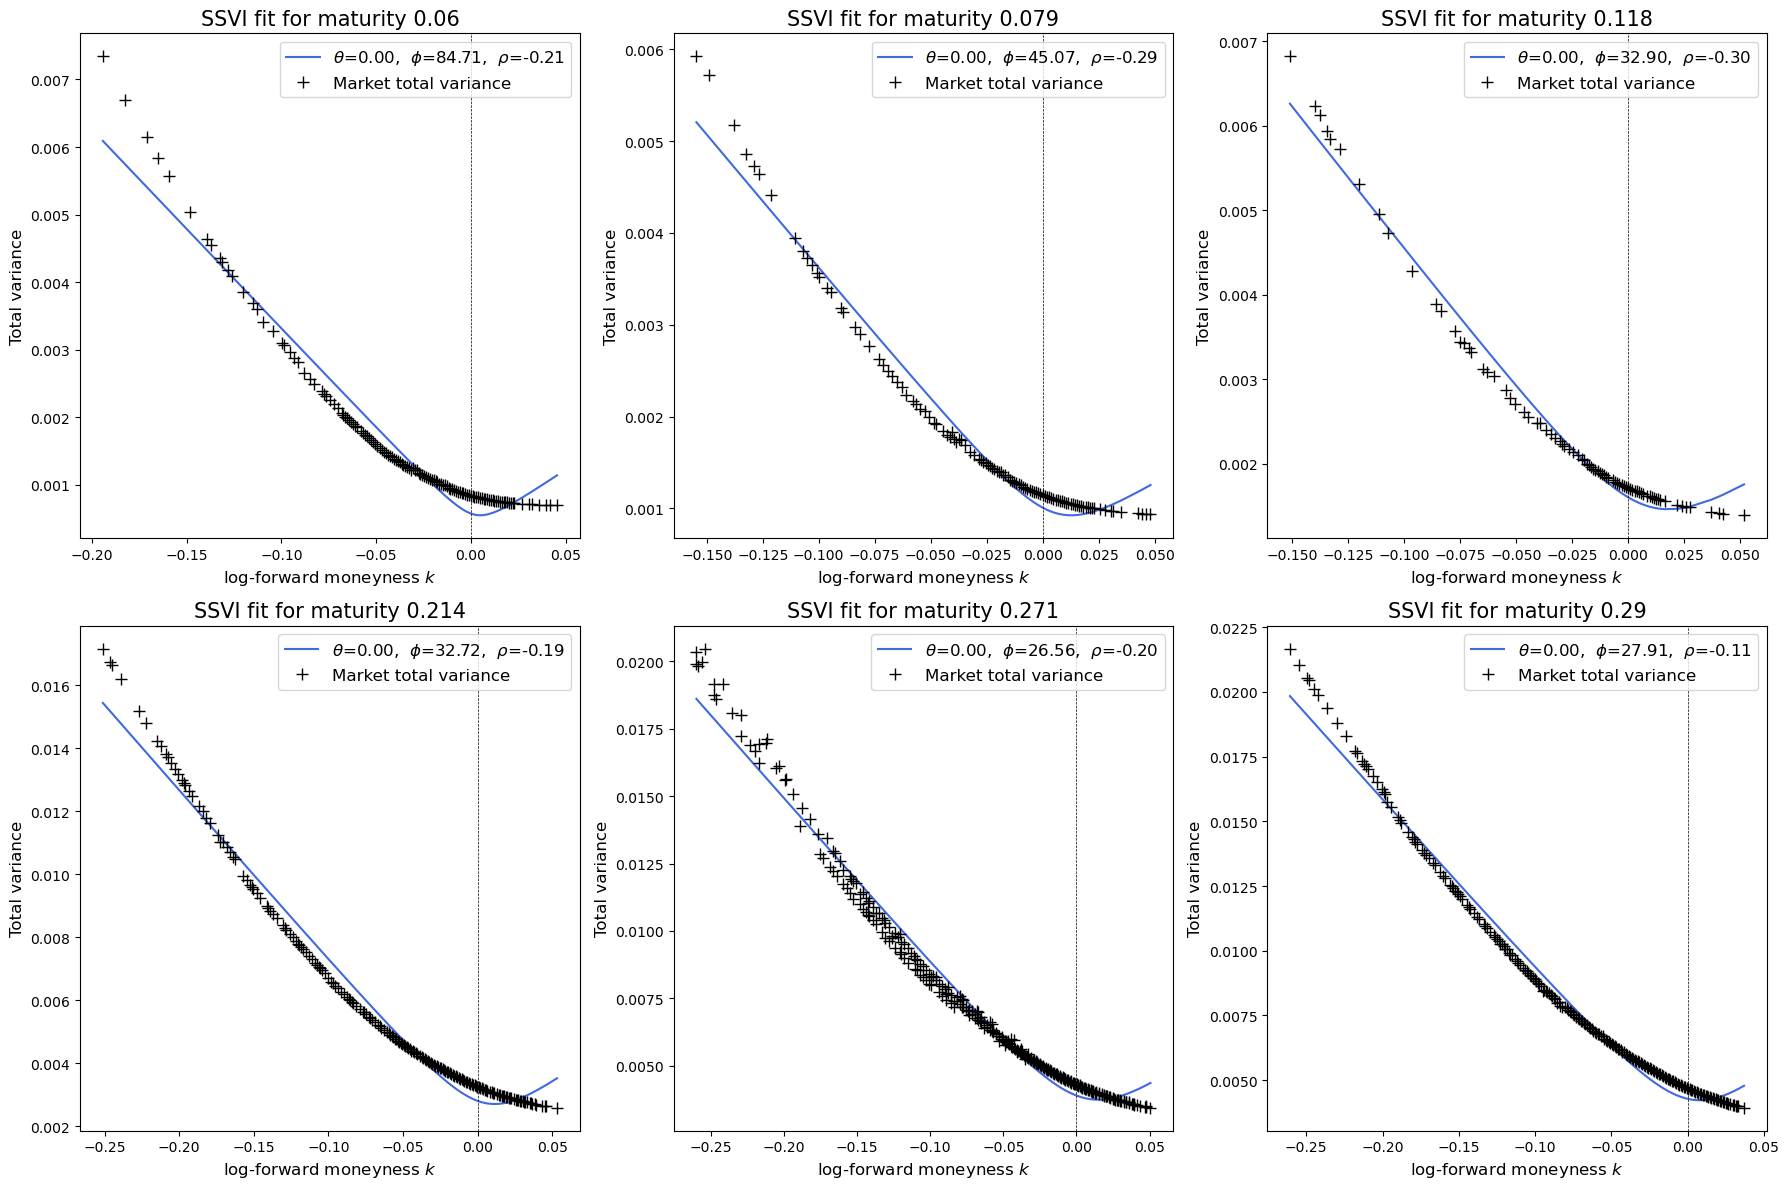

In [8]:
#######################################
## Plot of the calibrated SVI model
#######################################

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, maturity in enumerate(maturities):
    mkt_log_mon = mkt_log_mon_dict[maturity]
    vols_calls = vols_calls_dict[maturity]

    theta_star = theta_star_dict[maturity]
    phi_star = phi_star_dict[maturity]
    rho_star = rho_star_dict[maturity]

    total_variances_fit = SSVI(mkt_log_mon, theta_star, phi_star, rho_star)
    mkt_tot_variance = maturity * vols_calls**2

    ax = axes[i]
    ax.plot(mkt_log_mon, total_variances_fit, color='royalblue', linewidth=1.5, label=r"$\theta$=%1.2f,  $\phi$=%1.2f,  $\rho$=%1.2f" % (theta_star, phi_star, rho_star))
    ax.plot(mkt_log_mon, mkt_tot_variance, color='black', linewidth=0., marker="+", markersize=8, label="Market total variance")
    ax.axvline(0., linestyle="--", linewidth=0.5, color="k")
    ax.set_xlabel(r"log-forward moneyness $k$", fontsize=12)
    ax.set_ylabel("Total variance", fontsize=12)
    ax.set_title(r"SSVI fit for maturity " + str(maturity), fontsize=15)
    ax.legend(loc="upper right", fontsize=12)

    
plt.tight_layout()
plt.show()


The calibration is a little bit less powerful than for the SVI model, which is to be expected.

The fit of the corresponding implied volatility:

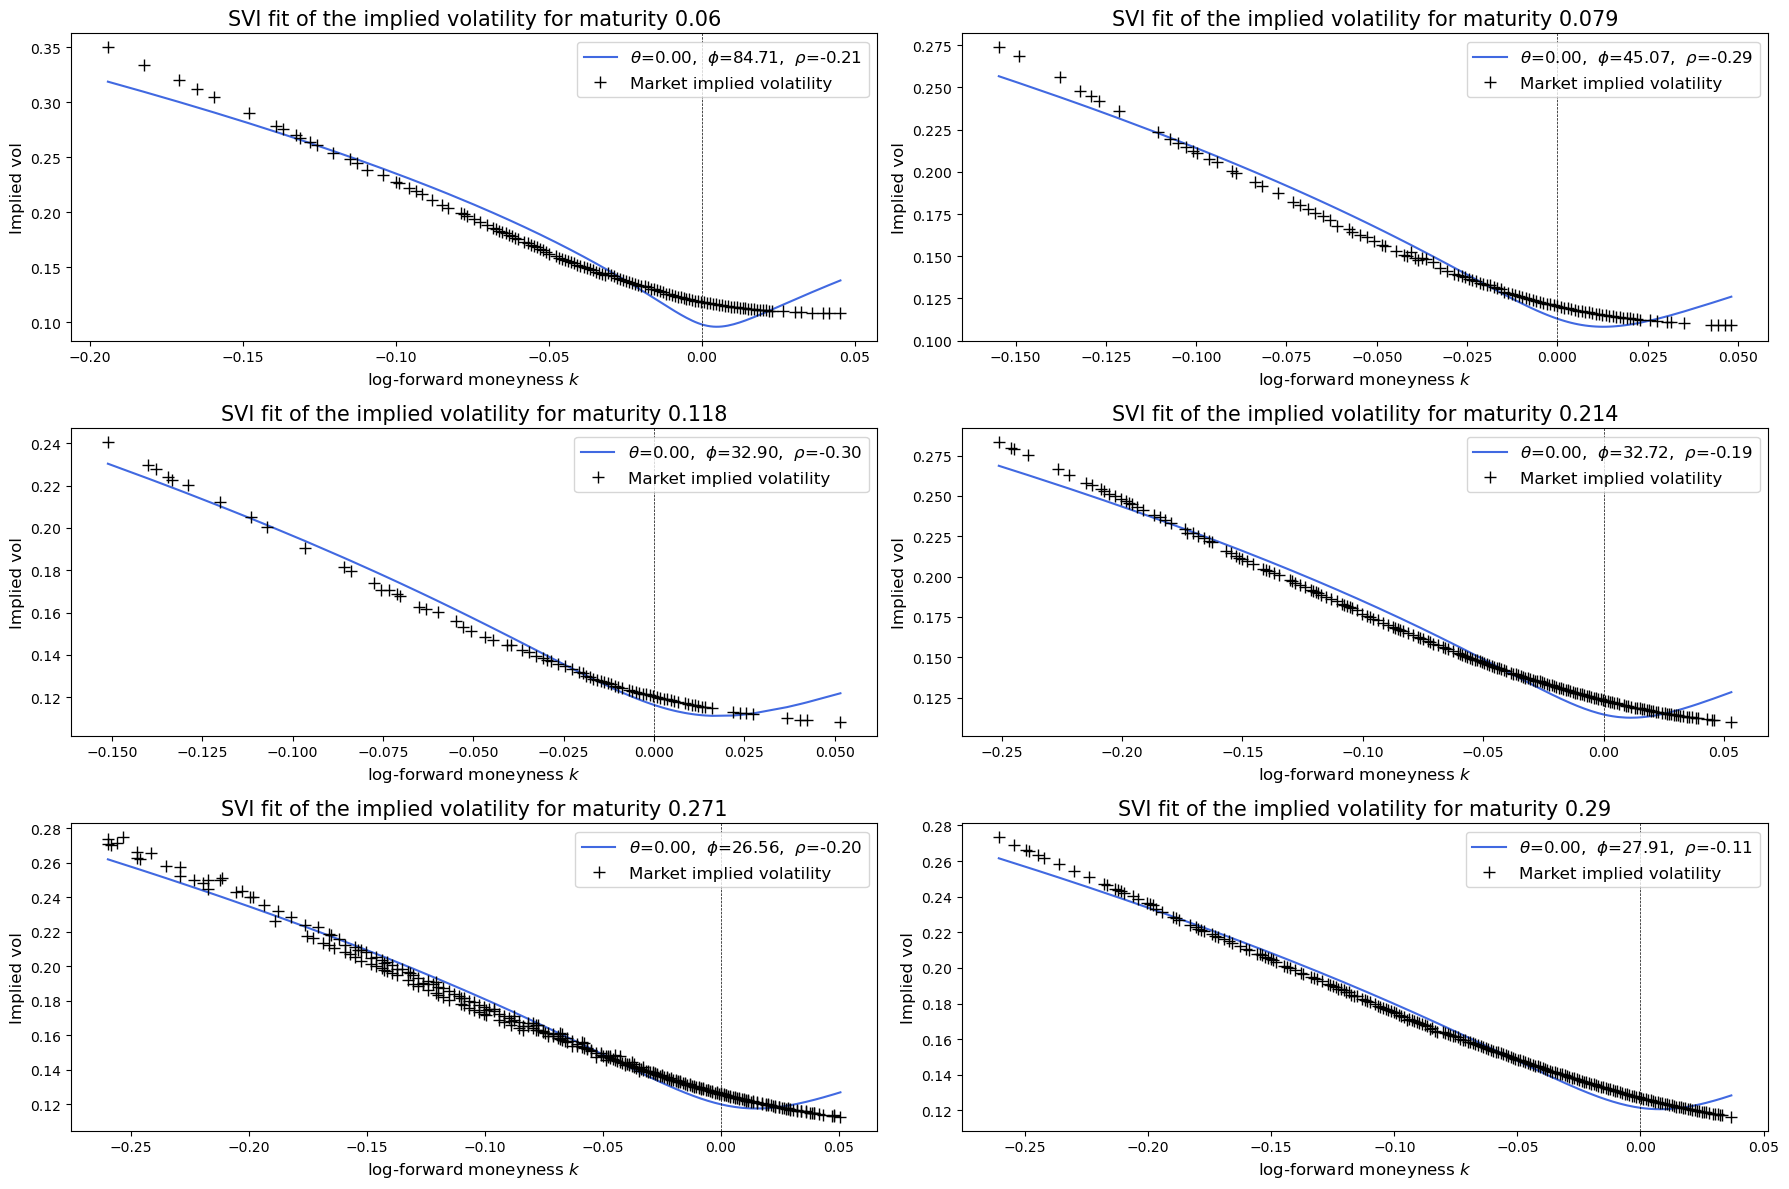

In [9]:
#####################################
## Plot of SVI fit of implied vol
#####################################

fig, axes = plt.subplots(3, 2, figsize=(18, 12)) 
axes = axes.flatten()

for i, maturity in enumerate(maturities):
    mkt_log_mon = mkt_log_mon_dict[maturity]
    vols_calls = vols_calls_dict[maturity]

    theta_star = theta_star_dict[maturity]
    phi_star = phi_star_dict[maturity]
    rho_star = rho_star_dict[maturity]

    total_variances_fit = SSVI(mkt_log_mon, theta_star, phi_star, rho_star)
    mkt_tot_variance = maturity * vols_calls**2
    implied_vols_fit = np.sqrt(total_variances_fit/maturity)

    ax = axes[i]
    ax.plot(mkt_log_mon, implied_vols_fit, color='royalblue', linewidth=1.5, label=r"$\theta$=%1.2f,  $\phi$=%1.2f,  $\rho$=%1.2f" % (theta_star, phi_star, rho_star))
    ax.plot(mkt_log_mon, vols_calls, color='black', linewidth=0., marker="+", markersize=8, label="Market implied volatility")
    ax.axvline(0., linestyle="--", linewidth=0.5, color="k")
    ax.set_xlabel(r"log-forward moneyness $k$", fontsize=12)
    ax.set_ylabel("Implied vol", fontsize=12)
    ax.set_title(f"SVI fit of the implied volatility for maturity {maturity}", fontsize=15)
    ax.legend(loc="upper right", fontsize=12)

plt.tight_layout()
plt.show()


## Testing the no arbitrage conditions for the SSVI parametrisation of the implied volatility

Thanks to the reduced complexity (3 parameters instead of 5), the no-butterfly arbitrage conditions 1) and 3) from the lecture notes on a SSVI slice can be replaced with much simpler conditions on the parameters $(\theta, \varphi, \rho)$, given in [Gatheral and Jacquier 2014], Theorem 4.2, which states that the no-arbitrage conditions 1) and 3) are satisfied if

$$
\left\{
\begin{aligned}
&\theta \, \varphi \, (1+|\rho|) < 4
\\
&\theta \, \varphi^2 \, (1+|\rho|) \le 4.
\end{aligned}
\right.
$$

In [10]:
def test_1(theta, phi, rho):
    if (theta * phi * (1+np.abs(rho)) <= 4):
        print("\n Test 1: Passed \n")
    else:
        print("\n Test 1: Failed \n")
    return 0

def test_2(theta, phi, rho):
    if (theta * phi**2 * (1+np.abs(rho)) <= 4):
        print("\n Test 2: Passed \n")
    else:
        print("\n Test 2: Failed \n")

    return 0

In [11]:
for maturity in maturities:
    
    theta_star = theta_star_dict[maturity] 
    phi_star = phi_star_dict[maturity] 
    rho_star = rho_star_dict[maturity]
    
    print(f"Testing the no arbitrage butterfly conditions with maturity {maturity}")
    test_1(theta_star, phi_star, rho_star)
    test_2(theta_star, phi_star, rho_star)


Testing the no arbitrage butterfly conditions with maturity 0.06

 Test 1: Passed 


 Test 2: Failed 

Testing the no arbitrage butterfly conditions with maturity 0.079

 Test 1: Passed 


 Test 2: Passed 

Testing the no arbitrage butterfly conditions with maturity 0.118

 Test 1: Passed 


 Test 2: Passed 

Testing the no arbitrage butterfly conditions with maturity 0.214

 Test 1: Passed 


 Test 2: Passed 

Testing the no arbitrage butterfly conditions with maturity 0.271

 Test 1: Passed 


 Test 2: Passed 

Testing the no arbitrage butterfly conditions with maturity 0.29

 Test 1: Passed 


 Test 2: Passed 



(Almost) all of the SSVI parametrizations pass both tests.

The __no-calendar spread arbitrage condition__ from the lectures:

2) The function $T \mapsto w_\mathrm{SSVI}(T, k) $ is increasing, for every $k \in \mathbb R$,

can also be reformulated as a simple condition on the functions $\theta_\cdot$ and $\varphi(\cdot)$, see [Gatheral and Jacquier, 2014](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2033323), Theorem 4.1:

$$
\left\{
\begin{aligned}
&T \mapsto \theta_T \mbox{ is increasing }
\\
&0 
\le
\partial_\theta (\theta \, \varphi(\theta))
\le
\frac1{\rho^2} \left(1+ \sqrt{1-\rho^2}\right) \varphi(\theta) \qquad \forall \theta,
\end{aligned}
\right.
$$

where, in the second line, we have supposed that the functions $\theta_\cdot$ and $\varphi(\cdot)$ are differentiable.

C:\Users\alae-\AppData\Local\Temp\ipykernel_23352\1264210436.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(np.c_[np.ones(len(maturities)), np.array(maturities)], list(theta_star_dict.values()))


Text(0.5, 1.0, 'Choice for $T \\rightarrow \\theta(T)$')

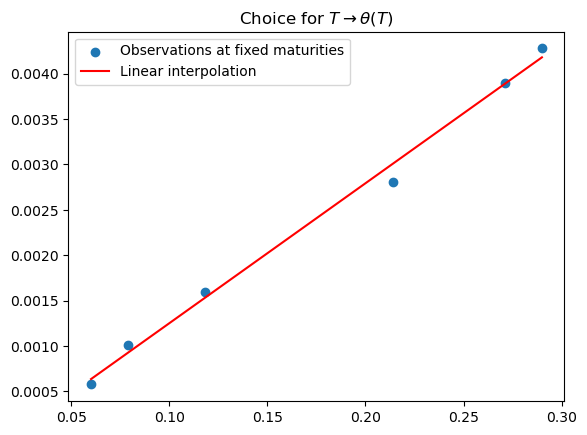

In [12]:
# Choice for the function theta(T) : linear interpolation

def theta(T):
    x = np.linalg.lstsq(np.c_[np.ones(len(maturities)), np.array(maturities)], list(theta_star_dict.values()))    
    slope = x[0][1]
    intercept = x[0][0]
    return(intercept + slope*T)

plt.scatter(maturities, list(theta_star_dict.values()), label = "Observations at fixed maturities")
plt.plot(maturities, [theta(maturity) for maturity in maturities], color = "r", label = "Linear interpolation")
plt.legend()
plt.title(r"Choice for $T \rightarrow \theta(T)$")

For the function parametrization of $\varphi(\theta)$, we use the example provided by [Gatheral and Jacquier 2014] :

$$\varphi(\theta)=\frac{\eta}{\theta^\gamma(1+\theta)^{1-\gamma}}$$

In [13]:
def phi(eta, gamma, theta):
    return eta/(theta**gamma * (1+theta)**(1-gamma))

In [14]:
import numpy as np
from scipy.optimize import minimize

def objective_function(params, theta_star, phi_star):
    eta, gamma = params
    errors = [phi(eta, gamma, theta) - phi_obs for theta, phi_obs in zip(theta_star, phi_star)]
    sse = sum(error**2 for error in errors)
    return sse

params_initial = np.array([1, 0.25]) 
bounds = [(0, 2), (0, 1)] # see the paper

result = minimize(objective_function, params_initial, args=(theta_star_dict.values(), phi_star_dict.values()), bounds=bounds, method='L-BFGS-B')

print(f'Optimized params: {result.x}')

Optimized params: [0.66406076 0.63945876]


We compute :

$$ \partial_\theta (\theta \, \varphi(\theta)) = \partial_\theta (\frac{\eta\theta^{1-\gamma}}{(1+\theta)^{1-\gamma}}) = \eta  \partial_\theta (\frac{\theta}{1+\theta})^{1-\gamma} = \eta (1-\gamma) \frac1{(1+\theta)^2} (\frac{\theta}{1+\theta})^{-\gamma}$$

Since we do not know what parameter \rho to choose for the upper bound $\frac1{\rho^2} \left(1+ \sqrt{1-\rho^2}\right) \varphi(\theta)$, we take $\rho^2 = 1$ which minimizes this bound (so if there is no arbitrage with that bound (so if there is no arbitrage with this value of $\rho$, the condition would be satisfied with every $\rho$)

In [15]:
eta_opt, gamma_opt = result.x

def derivative_phi(theta):
    return eta_opt*(1-gamma_opt) * 1/(1+theta)**2 * (theta/(1+theta))**(-gamma_opt)

def bound(theta): 
    return phi(eta_opt, gamma_opt, theta)

C:\Users\alae-\AppData\Local\Temp\ipykernel_23352\1264210436.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(np.c_[np.ones(len(maturities)), np.array(maturities)], list(theta_star_dict.values()))


Text(0.5, 1.0, 'Verification of the no-calendar spread arbitrage condition')

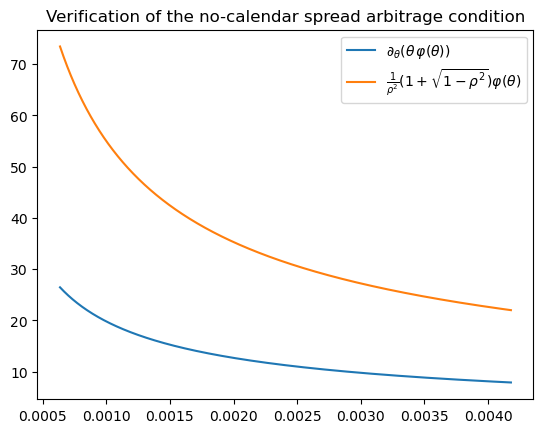

In [16]:
T = np.linspace(0.06, 0.29, 1000)
theta_val = theta(T)

plt.plot(theta_val, derivative_phi(theta_val), label = r"$\partial_\theta (\theta \, \varphi(\theta))$")
plt.plot(theta_val, bound(theta_val), label = r"$\frac{1}{\rho^2} (1+ \sqrt{1-\rho^2})\varphi(\theta)$")

plt.legend()
plt.title("Verification of the no-calendar spread arbitrage condition")

The no-calendar spread arbitrage condition is satisfied.